In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from torch import nn

import pandas as pd
import os
import pathlib
import shutil
import cv2
import PIL

TEXT_COLOR = 'black'

# Зафиксируем состояние случайных чисел
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
PROJECT_ROOT = pathlib.Path(os.path.abspath(os.path.join(os.curdir, os.pardir)))
DATA_DIR = PROJECT_ROOT / 'data' / 'rtsd-r3'
full_gt = pd.read_csv(DATA_DIR / 'full-gt.csv')
detection_srt = pathlib.Path(DATA_DIR / 'full-frames/rtsd-frames')
full_gt

,filename,x_from,y_from,width,height,sign_class,sign_id
0,autosave01_02_2012_09_13_33.jpg,649,376,18,18,2_1,0
1,autosave01_02_2012_09_13_34.jpg,671,356,20,21,2_1,0
2,autosave01_02_2012_09_13_35.jpg,711,332,27,26,2_1,0
3,autosave01_02_2012_09_13_36.jpg,764,290,37,36,2_1,0
4,autosave01_02_2012_09_13_36.jpg,684,384,17,17,1_23,1
...,...,...,...,...,...,...,...
104353,autosave24_10_2013_13_18_37_1.jpg,622,394,27,16,5_15_7,2565
104354,autosave24_10_2013_13_18_37_2.jpg,638,387,31,18,5_15_7,2565
104355,autosave24_10_2013_13_18_38_0.jpg,647,385,33,20,5_15_7,2565
104356,autosave24_10_2013_13_18_38_1.jpg,668,378,41,23,5_15_7,2565


In [3]:
def showPicture(path=None, full_gt_index=None, img=None, ax=None, figsize=(5, 5)):
    if img.any() != None:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    if path != None:
        pass
    else:
        if full_gt_index == None:
            assert 1 != 0, '1'
        else:
            path = train_dir / full_gt.iloc[full_gt_index]['filename']
        
            img = cv2.imread(str(path))
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    fig = plt.figure(figsize=figsize)
    
    plt.imshow(img)
    plt.axis('off')
    # plt.show()

def getRandomImagePath():
    return str(detection_srt / full_gt.sample()['filename'].values[0])


def getSignCoordinates(path=None, filename=None):
    if path == None and filename == None:
        assert 1 != 0, 'cannot identify picture'
    if path:
        filename = str(path).split(sep='\\')[-1]
    located_data = full_gt.loc[full_gt['filename'] == filename]
    return located_data[['x_from', 'y_from', 'width', 'height', 'sign_class']].to_numpy()
    
        
def getMaskedImage(path=None, filename=None):
    if path == None and filename == None:
        assert 1 != 0, 'cannot identify picture'
    if path:
        filename = str(path).split(sep='\\')[-1]
    
    img = cv2.imread(str(detection_srt / filename))
    mask = np.zeros(img.shape[:2], dtype="uint8")
        
    for sign in getSignCoordinates(filename=filename):        
        cv2.rectangle(mask, (sign[0], sign[1]), (sign[0] + sign[2], sign[1] + sign[3]), 255, -1)
        
    return cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)

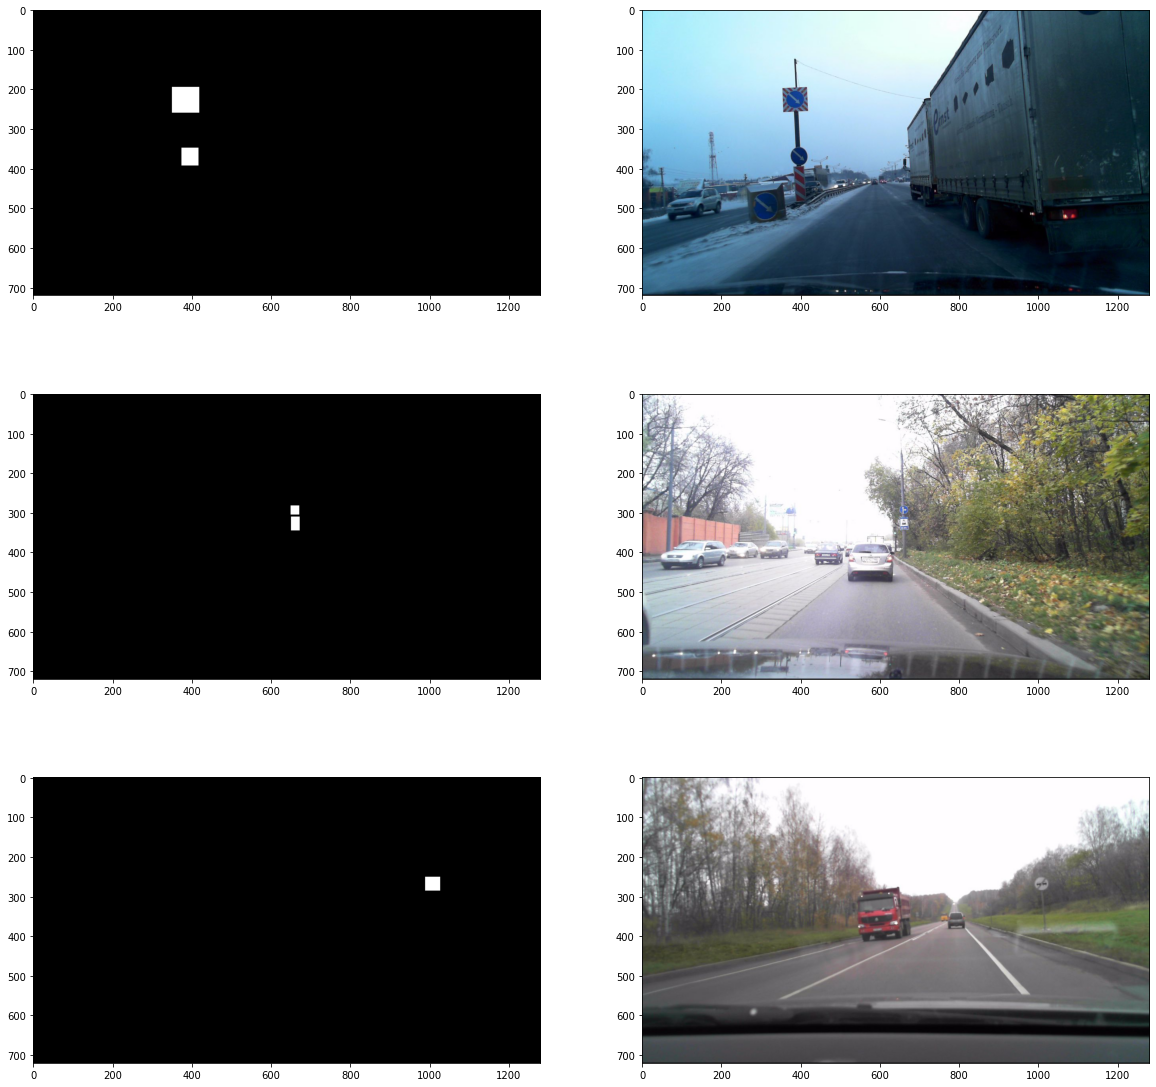

In [4]:
# getSignCoordinates(filename='autosave16_04_2013_12_01_56_1.jpg') # 3
# getSignCoordinates(filename='autosave01_02_2012_09_13_33.jpg')   # 1
# getSignCoordinates(filename='autosave01_02_2012_09_13_32.jpg')     # 0
# getMaskedImage(filename='autosave16_04_2013_12_01_56_1.jpg')


img=getMaskedImage(getRandomImagePath())

f = plt.figure(figsize=(20,20))


for i in range(6):
    ax = f.add_subplot(3, 2, i+1)
    # sampleImagePath = getRandomImagePath()
    
    if (i % 2 == 0):
        sampleImagePath = getRandomImagePath()
        ax.imshow(getMaskedImage(sampleImagePath))
    else:
        img = cv2.imread(sampleImagePath)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        ax.imshow(img)
        
        
plt.show()
# showPicture(img=getMaskedImage(getRandomImagePath()))

In [7]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
imgs = ['https://ultralytics.com/images/zidane.jpg']  # batch of images

# Inference
results = model(imgs)

Using cache found in C:\Users\admin/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2021-11-10 torch 1.8.0+cu111 CUDA:0 (NVIDIA GeForce GTX 950, 2048MiB)

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [15]:
results.print()

image 1/1: 720x1280 2 persons, 1 tie
Speed: 687.8ms pre-process, 31.3ms inference, 0.0ms NMS per image at shape (1, 3, 384, 640)


In [20]:
# results.show()
results.pandas().xyxy[0]

,xmin,ymin,xmax,ymax,confidence,class,name
0,752.00,45.75,1148.0,716.0,0.875977,0,person
1,100.25,201.50,1001.0,718.5,0.572266,0,person
2,438.50,422.25,510.0,720.0,0.525879,27,tie


In [13]:
model

AutoShape(
  (model): Model(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C3(
        (cv1): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv3): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): Sequential(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (co

In [6]:
import torch
import torchvision

device = 'cuda'
boxes = torch.tensor([[0., 1., 2., 3.]]).to(device)
scores = torch.randn(1).to(device)
iou_thresholds = 0.5

print(torchvision.ops.nms(boxes, scores, iou_thresholds))

tensor([0], device='cuda:0')
